In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
df = pd.read_csv("data.csv")

In [36]:
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [37]:
def normalize(data):
    return (data - np.min(data, axis=0)) / (np.max(data, axis=0) - np.min(data, axis=0))


In [38]:
features = df.drop(columns=['country']).values
scaled_features = normalize(features)

In [39]:
def pca(data, n_components):
    # Center the data
    mean_centered = data - np.mean(data, axis=0)
    # Compute covariance matrix
    covariance_matrix = np.cov(mean_centered, rowvar=False)
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    eigenvalues = eigenvalues[sorted_indices]
    # Select top 'n_components' eigenvectors
    principal_components = eigenvectors[:, :n_components]
    # Project data onto principal components
    reduced_data = np.dot(mean_centered, principal_components)
    return reduced_data


In [40]:
n_components = 3 # Reduce data to 2 dimensions
reduced_features = pca(scaled_features, n_components)


In [41]:
def kmeans(data, k, max_iters=100):
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    for _ in range(max_iters):
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return labels, centroids


In [42]:
kmeans_labels_pca, kmeans_centroids = kmeans(reduced_features, 3)


In [43]:
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.legend()
    plt.show()


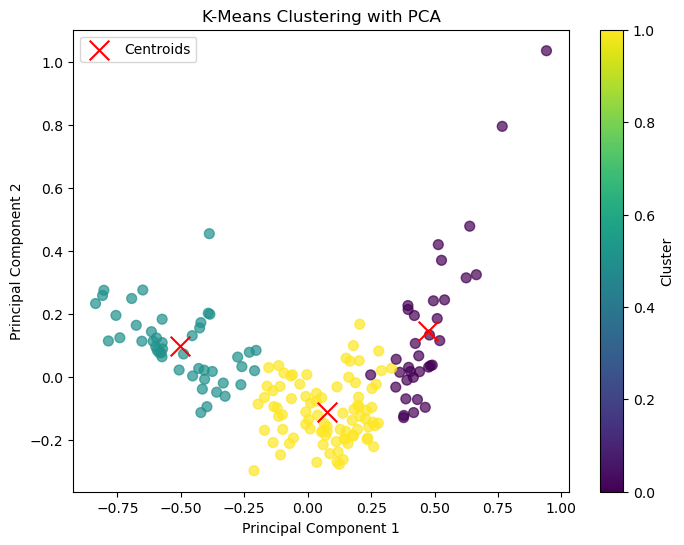

In [44]:
plot_clusters(reduced_features, kmeans_labels_pca, "K-Means Clustering with PCA")


In [45]:
def silhouette_score(data, labels):
    scores = []
    for i in range(len(data)):
        same_cluster = data[labels == labels[i]]
        other_cluster_indices = np.where(labels != labels[i])[0]
        a = np.mean(np.linalg.norm(same_cluster - data[i], axis=1))
        b = np.min([
            np.mean(np.linalg.norm(data[other_cluster_indices][labels[other_cluster_indices] == j] - data[i], axis=1))
            for j in set(labels) if j != labels[i]
        ])
        scores.append((b - a) / max(a, b))
    return np.mean(scores)



In [46]:
def davies_bouldin_index(data, labels, centroids):
    cluster_distances = []
    for i in range(len(centroids)):
        intra_cluster = np.mean(np.linalg.norm(data[labels == i] - centroids[i], axis=1))
        cluster_distances.append(intra_cluster)
    
    db_index = 0
    for i in range(len(centroids)):
        max_ratio = 0
        for j in range(len(centroids)):
            if i != j:
                inter_cluster = np.linalg.norm(centroids[i] - centroids[j])
                ratio = (cluster_distances[i] + cluster_distances[j]) / inter_cluster
                max_ratio = max(max_ratio, ratio)
        db_index += max_ratio
    return db_index / len(centroids)


In [47]:
def calculate_inertia(data, labels, centroids):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = data[labels == i]
        inertia += np.sum((cluster_points - centroids[i]) ** 2)
    return inertia

In [58]:
kmeans_labels_pca, kmeans_centroids_pca = kmeans(reduced_features, 3)
inertia_w_pca = calculate_inertia(reduced_features, kmeans_labels_pca, kmeans_centroids_pca)
silhouette_w_pca = silhouette_score(reduced_features, kmeans_labels_pca)
dbi_w_pca = davies_bouldin_index(reduced_features, kmeans_labels_pca, kmeans_centroids_pca)

print(f"K-Means Inertia with PCA: {inertia_w_pca}")
print(f"K-Means Silhouette Score with PCA: {silhouette_w_pca}")
print(f"K-Means Davies-Bouldin Index with PCA: {dbi_w_pca}")

K-Means Inertia with PCA: 11.270622261541487
K-Means Silhouette Score with PCA: 0.44911335878551634
K-Means Davies-Bouldin Index with PCA: 0.8695312402635328


In [59]:
kmeans_labels_no_pca, kmeans_centroids_no_pca = kmeans(scaled_features, 3)
inertia_no_pca = calculate_inertia(scaled_features, kmeans_labels_no_pca, kmeans_centroids_no_pca)
silhouette_no_pca = silhouette_score(scaled_features, kmeans_labels_no_pca)
dbi_no_pca = davies_bouldin_index(scaled_features, kmeans_labels_no_pca, kmeans_centroids_no_pca)

print(f"K-Means Inertia without PCA: {inertia_no_pca}")
print(f"K-Means Silhouette Score without PCA: {silhouette_no_pca}")
print(f"K-Means Davies-Bouldin Index without PCA: {dbi_no_pca}")

K-Means Inertia without PCA: 19.35198252576052
K-Means Silhouette Score without PCA: 0.3519718245714559
K-Means Davies-Bouldin Index without PCA: 1.11869863667507


In [60]:
def plot_elbow(data, max_k=10):
    
    inertias = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        _, centroids = kmeans(data, k)
        labels, _ = kmeans(data, k)
        inertia = calculate_inertia(data, labels, centroids)
        inertias.append(inertia)

    plt.figure(figsize=(8, 6))
    plt.plot(k_values, inertias, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.xticks(k_values)
    plt.grid()
    plt.show()


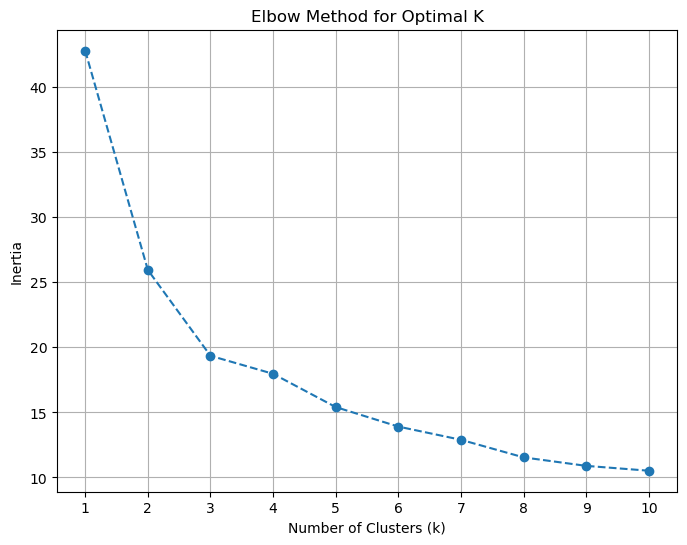

In [61]:
plot_elbow(scaled_features, max_k=10)

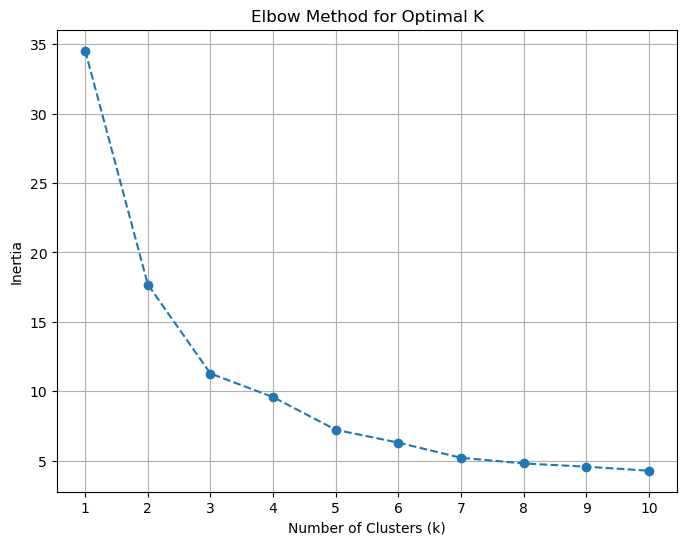

In [62]:
plot_elbow(reduced_features, max_k=10)

In [49]:
# Hierarchical Clustering
class HierarchicalClustering:
    def __init__(self, n_clusters=2):
        self.n_clusters = n_clusters

    def fit(self, data):
        self.data = data
        self.n_samples = data.shape[0]
        
        # Create a distance matrix to store distances between every pair of points
        self.distances = np.zeros((self.n_samples, self.n_samples))
        for i in range(self.n_samples):
            for j in range(i, self.n_samples):
                self.distances[i, j] = self.distances[j, i] = np.linalg.norm(data[i] - data[j])
        
        # Initialize clusters (each point is its own cluster)
        self.clusters = [[i] for i in range(self.n_samples)]
        
        # Perform agglomerative clustering
        while len(self.clusters) > self.n_clusters:
            # Find the two closest clusters
            min_dist = np.inf
            cluster_to_merge = (None, None)
            for i in range(len(self.clusters)):
                for j in range(i + 1, len(self.clusters)):
                    dist = self.calculate_cluster_distance(self.clusters[i], self.clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        cluster_to_merge = (i, j)

            # Merge the two closest clusters
            cluster_i, cluster_j = cluster_to_merge
            self.clusters[cluster_i] = self.clusters[cluster_i] + self.clusters[cluster_j]
            del self.clusters[cluster_j]

    def calculate_cluster_distance(self, cluster_i, cluster_j):
        min_distance = np.inf
        for i in cluster_i:
            for j in cluster_j:
                distance = self.distances[i, j]
                if distance < min_distance:
                    min_distance = distance
        return min_distance

    def predict(self):
        # Return cluster labels based on the final clusters
        labels = np.zeros(self.n_samples)
        for cluster_id, cluster in enumerate(self.clusters):
            for point in cluster:
                labels[point] = cluster_id
        return labels
    
    def silhouette_score(self, labels):
        scores = []
        for i in range(len(self.data)):
            same_cluster = self.data[labels == labels[i]]
            other_cluster_indices = np.where(labels != labels[i])[0]
            a = np.mean(np.linalg.norm(same_cluster - self.data[i], axis=1))
            b = np.min([
                np.mean(np.linalg.norm(self.data[other_cluster_indices][labels[other_cluster_indices] == j] - self.data[i], axis=1))
                for j in set(labels) if j != labels[i]
            ])
            scores.append((b - a) / max(a, b))
        return np.mean(scores)
    
    def davies_bouldin_index(self, labels):
        centroids = np.array([self.data[labels == i].mean(axis=0) for i in np.unique(labels)])
        cluster_distances = []
        for i in range(len(centroids)):
            intra_cluster = np.mean(np.linalg.norm(self.data[labels == i] - centroids[i], axis=1))
            cluster_distances.append(intra_cluster)

        db_index = 0
        for i in range(len(centroids)):
            max_ratio = 0
            for j in range(len(centroids)):
                if i != j:
                    inter_cluster = np.linalg.norm(centroids[i] - centroids[j])
                    ratio = (cluster_distances[i] + cluster_distances[j]) / inter_cluster
                    max_ratio = max(max_ratio, ratio)
            db_index += max_ratio
        return db_index / len(centroids)
    

    
    

In [50]:
from scipy.cluster.hierarchy import linkage, dendrogram

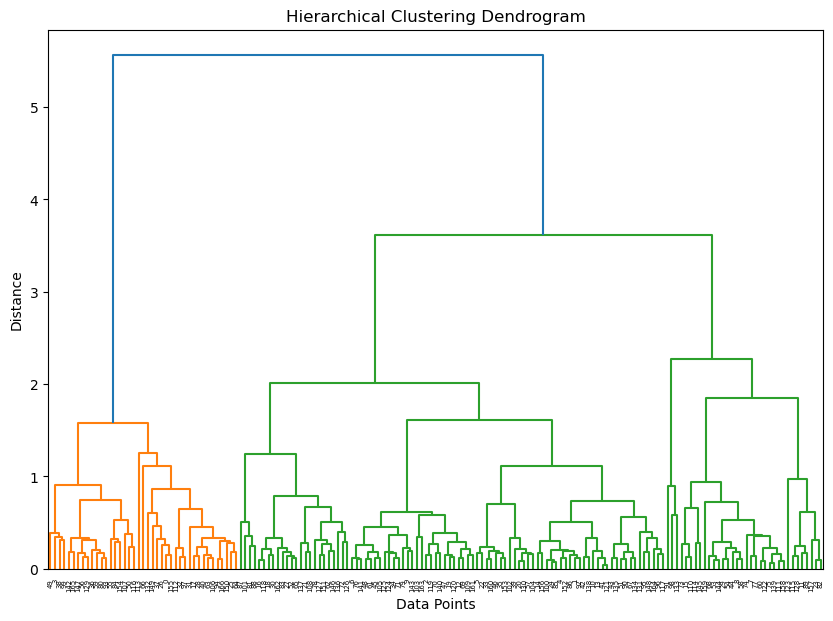

In [51]:
linked = linkage(scaled_features, 'ward')  # Use 'ward' linkage method for agglomerative clustering

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


In [52]:
hc = HierarchicalClustering(n_clusters=3)
hc.fit(reduced_features)
hierarchical_labels = hc.predict()

In [53]:
hc_silhouette = hc.silhouette_score(hierarchical_labels)
hc_dbi = hc.davies_bouldin_index(hierarchical_labels)

In [54]:
print(f"Hierarchical Clustering Silhouette Score with PCA: {hc_silhouette}")
print(f"Hierarchical Clustering Davies-Bouldin Index with PCA: {hc_dbi}")


Hierarchical Clustering Silhouette Score with PCA: 0.5837087581775549
Hierarchical Clustering Davies-Bouldin Index with PCA: 0.2943383189512118


In [55]:
def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

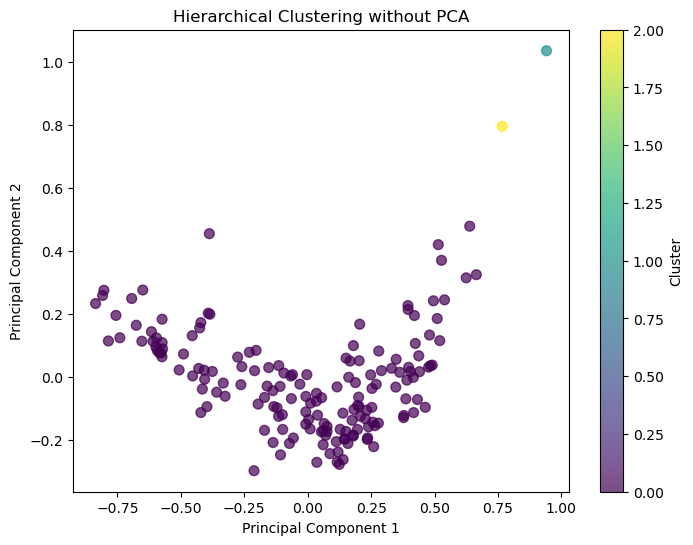

In [56]:
plot_clusters(reduced_features, hierarchical_labels, 'Hierarchical Clustering without PCA')

In [57]:
hc.fit(scaled_features)
hierarchical_labels = hc.predict()
hc_silhouette = hc.silhouette_score(hierarchical_labels)
hc_dbi = hc.davies_bouldin_index(hierarchical_labels)
print(f"Hierarchical Clustering Silhouette Score without PCA: {hc_silhouette}")
print(f"Hierarchical Clustering Davies-Bouldin Index without PCA: {hc_dbi}")

Hierarchical Clustering Silhouette Score without PCA: 0.4406116992885483
Hierarchical Clustering Davies-Bouldin Index without PCA: 0.36274499466739557


In [63]:
def knn_predict(train_data, train_labels, test_data, k=5):
    predictions = []
    for test_point in test_data:
        distances = np.linalg.norm(train_data - test_point, axis=1)
        nearest_indices = np.argsort(distances)[:k]
        nearest_labels = train_labels[nearest_indices]
        unique_labels, counts = np.unique(nearest_labels, return_counts=True)
        predictions.append(unique_labels[np.argmax(counts)])
    return np.array(predictions)

In [64]:
def manual_train_test_split(data, labels, test_size=0.3, random_state=42):
    np.random.seed(random_state)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    
    split_index = int(len(data) * (1 - test_size))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]
    
    return data[train_indices], data[test_indices], labels[train_indices], labels[test_indices]

In [65]:
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = manual_train_test_split(
    scaled_features, kmeans_labels_no_pca
)
X_train_hc, X_test_hc, y_train_hc, y_test_hc = manual_train_test_split(
    scaled_features, hierarchical_labels
)

# %% KNN Predictions for K-Means and Hierarchical
y_pred_kmeans = knn_predict(X_train_kmeans, y_train_kmeans, X_test_kmeans, k=5)
y_pred_hc = knn_predict(X_train_hc, y_train_hc, X_test_hc, k=5)

In [88]:
import seaborn as sns

def confusion_matrix(true_labels, predicted_labels):
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    cm = np.zeros((len(unique_labels), len(unique_labels)), dtype=int)
    
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    
    # Populate the confusion matrix
    for true, pred in zip(true_labels, predicted_labels):
        cm[label_map[true], label_map[pred]] += 1
        
    return cm, unique_labels

def accuracy(true_labels, predicted_labels):
    return np.mean(true_labels == predicted_labels)

# Function to calculate precision
def precision(true_labels, predicted_labels):
    cm, unique_labels = confusion_matrix(true_labels, predicted_labels)
    precision_values = np.diag(cm) / np.sum(cm, axis=0)  # Precision = TP / (TP + FP)
    
    precision_values = np.nan_to_num(precision_values)  # Replace NaNs with zeros (if any)
    return np.nanmean(precision_values)  # Average precision

# Function to calculate recall
def recall(true_labels, predicted_labels):
    cm, unique_labels = confusion_matrix(true_labels, predicted_labels)
    recall_values = np.diag(cm) / np.sum(cm, axis=1)  # Recall = TP / (TP + FN)
    
    recall_values = np.nan_to_num(recall_values)  # Replace NaNs with zeros (if any)
    return np.nanmean(recall_values)  # Average recall

# Function to calculate F1 score
def f1_score(true_labels, predicted_labels):
    precision_val = precision(true_labels, predicted_labels)
    recall_val = recall(true_labels, predicted_labels)
    
    # F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
    return 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) != 0 else 0 

def plot_confusion_matrix(true_labels, predicted_labels):
    cm, unique_labels = confusion_matrix(true_labels, predicted_labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plotting the confusion matrix
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    
    # Setting axis labels
    ax.set_xticks(np.arange(len(unique_labels)))
    ax.set_yticks(np.arange(len(unique_labels)))
    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)
    
    # Rotating the tick labels for better visibility
    plt.xticks(rotation=45)
    
    # Adding text labels on each cell
    for i in range(len(unique_labels)):
        for j in range(len(unique_labels)):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    
    # Axis labels and title
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    plt.show()


In [89]:
accuracy_kmeans = accuracy(y_test_kmeans, y_pred_kmeans)
conf_matrix_kmeans = confusion_matrix(y_test_kmeans, y_pred_kmeans)
precision_kmeans = precision(y_test_kmeans, y_pred_kmeans)
recall_kmeans = recall(y_test_kmeans, y_pred_kmeans)
f1_kmeans = f1_score(y_test_kmeans, y_pred_kmeans)

Accuracy for K-Means: 0.9607843137254902
Confusion Matrix for K-Means:
(array([[24,  0,  0],
       [ 2, 15,  0],
       [ 0,  0, 10]]), array([0, 1, 2], dtype=int64))
Precision for K-Means: 0.9743589743589745
Recall for K-Means: 0.9607843137254902
F1 Score for K-Means: 0.96752403221616


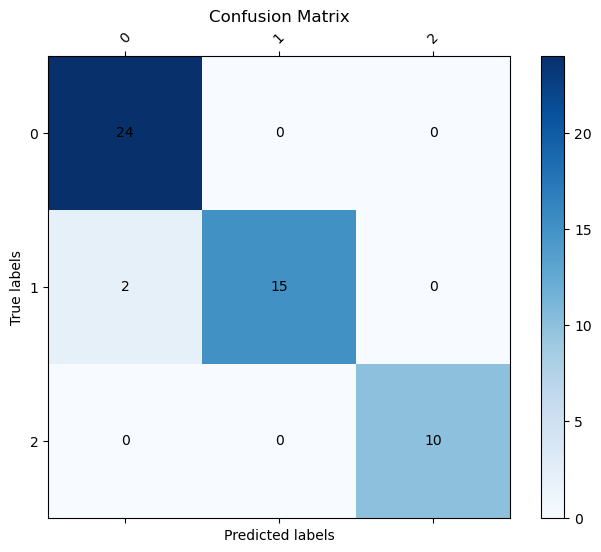

In [94]:
print(f"Accuracy for K-Means: {accuracy_kmeans}")
print(f"Confusion Matrix for K-Means:\n{conf_matrix_kmeans}")
print(f"Precision for K-Means: {precision_kmeans}")
print(f"Recall for K-Means: {recall_kmeans}")
print(f"F1 Score for K-Means: {f1_kmeans}")
plot_confusion_matrix(y_test_kmeans, y_pred_kmeans)

Accuracy for Hierarchical Clustering: 0.9607843137254902
Confusion Matrix for Hierarchical Clustering:
(array([[49,  0,  0],
       [ 1,  0,  0],
       [ 1,  0,  0]]), array([0., 1., 2.]))
Precision for Hierarchical Clustering: 0.32026143790849676
Recall for Hierarchical Clustering: 0.3333333333333333
F1 Score for Hierarchical Clustering: 0.32666666666666666


C:\Users\Mihika\AppData\Local\Temp\ipykernel_14108\4041180216.py:21: RuntimeWarning: invalid value encountered in divide
  precision_values = np.diag(cm) / np.sum(cm, axis=0)  # Precision = TP / (TP + FP)


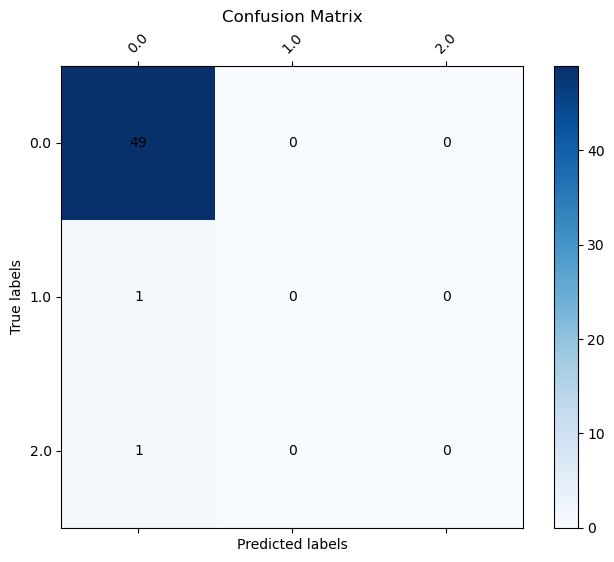

In [ ]:
y_pred_hc = knn_predict(X_train_hc, y_train_hc, X_test_hc, k=5)

# %% KNN Evaluation Metrics
accuracy_hc = accuracy(y_test_hc, y_pred_hc)
conf_matrix_hc = confusion_matrix(y_test_hc, y_pred_hc)
precision_hc = precision(y_test_hc, y_pred_hc)
recall_hc = recall(y_test_hc, y_pred_hc)
f1_hc = f1_score(y_test_hc, y_pred_hc)

# Print Results
print(f"Accuracy for Hierarchical Clustering: {accuracy_hc}")
print(f"Confusion Matrix for Hierarchical Clustering:\n{conf_matrix_hc}")
print(f"Precision for Hierarchical Clustering: {precision_hc}")
print(f"Recall for Hierarchical Clustering: {recall_hc}")
print(f"F1 Score for Hierarchical Clustering: {f1_hc}")

# %% Plot Confusion Matrix for Hierarchical Clustering
plot_confusion_matrix(y_test_hc, y_pred_hc)